***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com 

**Outline:**<br/>
**1️⃣ Importing the dataset**<br/>
**2️⃣ Convert the images into array & masks to binary**<br/>
**3️⃣ RGB to gray**<br/>
**4️⃣ [Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)**<br/>
**5️⃣ Augmentation**<br/>
**6️⃣ Crop images based on masks**<br/>
**7️⃣ Generate mask from image**<br/>

<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [1]:
import os
import cv2
import pprint
import numpy as np
from colorama import Fore
import matplotlib.pyplot as plt

from skimage import io, transform, color

from Functions.filepath_extractor import FilePathExtractor

<font color=#070bee size="4.5" face="Arial"><b>1️⃣ Importing the dataset</b></font><br/>
Load the medical images and their corresponding masks into the program.

In [2]:
# ================================================ Images ======================================================
img_format_type = "png"   # png, jpg, jpeg, tiff, bmp, tif, etc.
image_path = "D:/Medical-Image-Processing/Data/Membrance/images/"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path=image_path, format_type=img_format_type)
img_filesname = obj_inputs.filesname            # List of filesname in the directory with the specified extension
folders = obj_inputs.folders_path               # List of folders path where the files are located
all_files_path = obj_inputs.all_files_path      # List of full files path for the files
subfoldersname = obj_inputs.subfoldersname      # List of subfolders name within the directory

pprint.pprint({
               "File Names": img_filesname,
               "Folder Paths": folders,
               "Subfolder Names": subfoldersname
              }, compact=True, width=120, indent=1)

{'File Names': ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png',
                '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png',
                '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png'],
 'Folder Paths': ['D:/Medical-Image-Processing/Data/Membrance/images/'],
 'Subfolder Names': []}


In [3]:
# ==================================================== Masks ===================================================
mask_format_type = "png"  # png, jpg, jpeg, tiff, bmp, tif, etc.

mask_path = "D:/Medical-Image-Processing/Data/Membrance/masks/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path=mask_path, format_type=mask_format_type)
mask_filesname = obj_masks.filesname      # List of filesname in the directory with the specified extension
folders = obj_masks.folders_path           # List of folders path where the files are located
files_path = obj_masks.all_files_path      # List of full files path for the files
subfoldersname = obj_masks.subfoldersname  # List of subfolders name within the directory

pprint.pprint({
               "File Names": mask_filesname,
               "Folder Paths": folders,
               "Subfolder Names": subfoldersname
              }, compact=True, width=120, indent=1)

{'File Names': ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png',
                '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png',
                '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png'],
 'Folder Paths': ['D:/Medical-Image-Processing/Data/Membrance/masks/'],
 'Subfolder Names': []}


In [4]:
# ============================================ Check of the Images =============================================
# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(img_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

True

<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Convert the images into array</b></font><br/>
Transform images and masks into a format suitable for processing.<br/>
▪ Read each image file into an array using a library like skimage.io.<br/>
▪ Convert mask images into boolean arrays (e.g., 0 for background, 1 for foreground) to represent binary segmentation.<br/>

In [5]:
class ImageProcessor:
    """
    A class for processing image data, including loading, transforming, and augmenting images and masks.
    """
    def __init__(self):
        """
        Initialize the ImageProcessor class.

        Import module:
        - from Functions.image_processor import ImageProcessor

        Example:
        - obj = ImageProcessor()
        1. Images convert to ndarray (load_images)
           - imgs = obj.read_images(image_path, format_type="tif", resize=(224, 224), normalize=False, to_grayscale=False)
        2. Masks convert to binary or multi-class (load_masks)
           - masks = obj.read_masks(mask_path, format_type="tif", resize=(224, 224), normalize=False, to_grayscale=False)
        3. Save grayscale images (save_grayscale_images)
           - obj.save_grayscale_images(images=images, output_path=output_path, folder_name="Gray image")
        4. Generate mask from image (generate_mask_from_image)
           - images = obj.load_images("/path/to/images", "jpg")
           - masks = obj.generate_mask_from_image(images, method="otsu", output_path="/path/to/output")
        5. Augmentation (augmentation)
           - images = obj.load_images("/path/to/images", "jpg")
           - obj.augmentation(images "/path") 
        6. Crop images based on masks (crop_images_based_on_masks)
           - images = obj.load_images("/path/to/images", "jpg")
           - masks = obj.load_masks(masks_path, "tif")
           - cropped_imgs, cropped_masks = obj.mask_based_image_cropping(images, masks, resize=(256, 256))
        """

    # ============================================ Images convert to ndarray ===================================
    def read_images(self, image_path: str, format_type: str, resize: tuple = None, normalize: bool = False, 
                to_grayscale: bool = False) -> np.ndarray:
        """
        Convert images from a specified directory into a NumPy array with optional processing.

        Args:
        - image_path (str): The path to the directory containing the images.
        - format_type (str): The file format of the images (e.g., 'jpg', 'png', 'tif').
        - resize (tuple, optional): Target size as (height, width). Default is None.
        - normalize (bool, optional): Normalize pixel values if max > 1. Default is False.
        - to_grayscale (bool, optional): Convert images to grayscale. Default is False.

        Returns:
        - numpy.ndarray: A NumPy array containing all processed images.

        Example:
        - obj = ImageProcessor()
        - imgs = obj.read_images(image_path, format_type="tif", resize=(224, 224), normalize=False, to_grayscale=False)
                                
        Raises:
        - ValueError: If no files are found in the specified directory.
        """
        # Create an instance of FilePathExtractor to retrieve files path
        obj_path = FilePathExtractor(image_path, format_type)
        
        # Get a list of all files path in the specified directory
        files_path = obj_path.all_files_path

        # Check if the list of files path is empty
        if not files_path: raise ValueError("No files found in the specified directory.")

        # Get the total number of image files
        num_files = len(files_path)

        # Read the first image to determine base dimensions
        img = io.imread(files_path[0])
        # img = cv2.imread(files_path[0])
        
        # Convert to grayscale if specified
        if to_grayscale and img.ndim == 3: img = color.rgb2gray(img)
        # if to_grayscale: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Set target dimensions
        if resize:
            img_height, img_width = resize
        else:
            img_height, img_width = img.shape[:2]

        # Determine channels based on grayscale option
        channels = 1 if to_grayscale or img.ndim == 2 else img.shape[-1] if img.ndim == 3 else 1

        # Initialize array with appropriate shape
        imgs = np.zeros((num_files, img_height, img_width, channels),
                    dtype=np.float32 if normalize else np.uint8)

        # Load and process all images
        for idx, file_path in enumerate(files_path):
            # Read image
            img = io.imread(file_path)
            # img = cv2.imread(file_path)

            # Convert to grayscale if specified
            if to_grayscale and img.ndim == 3: img = color.rgb2gray(img)
            # if to_grayscale: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
            # Reshape if grayscale image lacks channel dimension
            if img.ndim == 2: img = np.expand_dims(img, axis=-1)
                
            # Resize if specified
            if resize:
                img = transform.resize(img, (img_height, img_width, channels), preserve_range=True)
                # img = cv2.resize(img, (img_width, img_height))
            
            # Normalize if specified and max value exceeds 1
            if normalize and img.max() > 1: img = img / 255.0
                
            imgs[idx] = img
        
        print(Fore.GREEN + f"Image shape: {imgs.shape}")
        
        return imgs

    # ================================= Masks convert to binary or Multi class =================================
    def read_masks(self, mask_path: str, format_type: str = "TIF", resize: tuple = None, normalize: bool = False, 
                num_classes: int = None) -> np.ndarray:
        """
        Convert mask images from a specified directory into a binary or multi-class NumPy array based on the mask
        type, using OpenCV, and count the number of classes.

        Args:
        - mask_path (str): The path to the directory containing the mask images.
        - format_type (str, optional): The file format of the mask images (default is "TIF").
        - resize (tuple, optional): Target size as (height, width). Default is None.
        - normalize (bool, optional): Normalize pixel values to [0, 1] if max > 1. Default is False.
        - num_classes (int, optional): Expected number of classes. If 2, forces binary conversion.

        Returns:
        - numpy.ndarray: A NumPy array of shape [num_files, height, width, 1], where:
            - Binary: 0 (background), 255 or 1 (foreground) if num_classes=2 or mask has 2 unique values.
            - Multi-class: Integer labels (e.g., 0, 1, 2, ...) if num_classes>2.
            - Normalized to [0, 1] if normalize=True.

        Example:
        - obj = ImageProcessor()
        - masks = obj.read_masks(mask_path, format_type="TIF", resize=(224, 224), normalize=False)

        Raises:
        - ValueError: If no files are found in the specified directory.
        """
        # Create an instance of FilePathExtractor to retrieve file paths
        obj_path = FilePathExtractor(mask_path, format_type)
        files_path = obj_path.all_files_path

        if not files_path:
            raise ValueError("No files found in the specified directory.")

        num_files = len(files_path)
        # Read the first mask to determine dimensions
        mask = cv2.imread(files_path[0], cv2.IMREAD_GRAYSCALE)

        # Set target dimensions
        img_height, img_width = resize if resize else mask.shape[:2]
        
        # Initialize array; use float32 if normalizing, uint8 otherwise
        masks = np.zeros((num_files, img_height, img_width, 1),
                        dtype=np.float32 if normalize else np.uint8)

        # Process all masks
        for ind, file_path in enumerate(files_path):
            # Read mask in grayscale mode
            mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Check unique values in the current mask
            unique_values = np.unique(mask)
            
            # Determine if we should force binary conversion
            force_binary = (num_classes == 2) or (len(unique_values) <= 2)

            # Handle binary or multi-class conversion
            if force_binary:
                # Convert to binary: 0 remains 0, all non-zero values become 255 (or 1 if normalized)
                if len(unique_values) > 2 and num_classes == 2:
                    mask = np.where(mask > 0, 255, 0).astype(np.uint8)  # Non-zero to 255, zero stays 0
                else:
                    # For masks that are already binary-like, ensure 0 and 255
                    mask = np.where(mask > 0, 255, 0).astype(np.uint8)
            else:
                # Preserve multi-class labels (no thresholding)
                mask = mask.astype(np.uint8)  # Ensure uint8 unless normalized

            # Normalize if specified
            if normalize:
                if mask.max() > 1:
                    mask = (mask / 255.0).astype(np.float32)  # Scale to [0, 1] (0 stays 0, 255 becomes 1)
                else:
                    mask = mask.astype(np.float32)  # Already in [0, 1] range

            # Resize if specified
            if resize:
                mask = cv2.resize(mask, (img_width, img_height), 
                                interpolation=cv2.INTER_NEAREST)  # Preserve discrete values
                if force_binary and not normalize:
                    mask = np.where(mask > 0, 255, 0).astype(np.uint8)  # Re-binarize after resizing to 0 and 255
                elif force_binary and normalize:
                    mask = np.where(mask > 0, 1.0, 0.0).astype(np.float32)  # Re-binarize to 0 and 1 if normalized

            # Add channel dimension and store
            masks[ind] = np.expand_dims(mask, axis=-1)

        # Analyze the final masks array for class counts
        unique_classes, class_counts = np.unique(masks, return_counts=True)
        detected_num_classes = len(unique_classes)

        print(Fore.GREEN + f"{masks.shape = }")
        print(Fore.YELLOW + f"Total number of classes in masks: {detected_num_classes}")

        # Detailed class counts
        if force_binary and not normalize:
            foreground_count = np.sum(masks == 1.0) if force_binary and normalize else np.sum(masks == 255)
            background_count = np.sum(masks == 0)
            print(Fore.YELLOW + f"Number of 1s or 255s (foreground): {foreground_count}")
            print(Fore.YELLOW + f"Number of 0s (background): {background_count}")
        else:
            print(Fore.YELLOW + "Class counts in masks:")
            for cls, count in zip(unique_classes, class_counts):
                if normalize:
                    print(Fore.YELLOW + f"  Class {cls:.2f}: {count}")
                else:
                    print(Fore.YELLOW + f"  Class {int(cls)}: {count}")

        return masks

    # ========================================= Save grayscale images ==========================================
    def save_grayscale_images(self, images: np.ndarray, output_path: str, folder_name: str = "Gray image") -> None:
        """
        Save images as grayscale to a specified directory, converting from RGB/BGR if needed.

        Args:
        - images (np.ndarray): A NumPy array of shape (num_files, height, width, channels).
        - output_path (str): The directory path where grayscale images will be saved.
        - folder_name (str, optional): The name of the folder to save the images in. Defaults to "Gray image".

        Returns:
        - None: Saves converted images to disk if RGB/BGR, otherwise prints a message.
        
        Example:
        - obj = ImageProcessor()
        - obj.save_grayscale_images(images=images, output_path=output_path, folder_name="Gray image")
            
        Raises:
        - ValueError: If the input images have an unexpected number of channels (not 1 or 3).
        - OSError: If the output directory cannot be created or accessed, or if saving an image fails.
        """
        # Check if images is a NumPy array with the expected shape
        if not isinstance(images, np.ndarray) or len(images.shape) != 4:
            raise ValueError("Input 'images' must be a 4D NumPy array (num_files, height, width, channels)")

        num_files, height, width, channels = images.shape

        # Validate channel count
        if channels not in [1, 3]:
            raise ValueError(f"Unexpected number of channels: {channels}. Expected 1 (grayscale) or 3 (RGB/BGR)")

        # Case 1: Images are already grayscale (1 channel)
        if channels == 1:
            print("Images are already grayscale; no conversion or saving needed.")
            return

        # Case 2: Images are RGB/BGR (3 channels), convert to grayscale and save
        # Create output directory if it doesn’t exist
        output_folder_path = os.path.join(output_path, folder_name)
        os.makedirs(output_folder_path, exist_ok=True)

        for i in range(num_files):
            # Extract the RGB/BGR image
            color_image = images[i, :, :, :]  # Shape: (height, width, 3)

            # If normalized (float values in [0, 1]), scale to [0, 255] for processing
            # This block ensures that the color_image is in the correct format (uint8) for OpenCV to process it correctly.
            # If the image's data type is float (either float32 or float64) and its maximum value is less than or equal to 1.0,
            # it's assumed to be a normalized image with pixel values in the range [0, 1].
            # In this case, the image is converted to the range [0, 255] by multiplying each pixel value by 255,
            # and then the data type is converted to uint8.
            if color_image.dtype in [np.float32, np.float64] and color_image.max() <= 1.0:
                color_image = (color_image * 255).astype(np.uint8)
            # If the image's data type is not already uint8, it's converted to uint8.
            # This handles cases where the image might be in a different integer format (e.g., int16, int32).
            elif color_image.dtype != np.uint8:
                color_image = color_image.astype(np.uint8)

            # Convert BGR to grayscale (assuming OpenCV’s BGR format; adjust if RGB)
            gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

            # Define the output filename
            filename = os.path.join(output_folder_path, f"{i:02d}.png")

            # Save the grayscale image
            success = cv2.imwrite(filename, gray_image)
            if not success:
                raise OSError(f"Failed to save image: {filename}")

        print(f"Converted {num_files} RGB/BGR images to grayscale and saved to {output_folder_path}")

    # ======================================= Generate mask from image =========================================
    def generate_mask_from_image(self, images: np.ndarray, method: str = "otsu", threshold: float = None, 
                            output_path: str = None, format_type: str = "png") -> np.ndarray:
        """
        Generate binary masks from images based on a specified method.

        Args:
        - images (np.ndarray): Input images array of shape [num_images, height, width, channels].
        - method (str, optional): Method to generate mask ("otsu", "threshold", "edges"; default: "otsu").
        - threshold (float, optional): Manual threshold value (0-255) if method="threshold" (default: None).
        - output_path (str, optional): Path to save masks in 'generated_masks' folder (default: None).
        - format_type (str, optional): File format for saving masks (default: "png").

        Returns:
        - np.ndarray: Binary masks array of shape [num_images, height, width, 1], values 0 or 1.

        Notes:
        - "otsu": Uses Otsu’s thresholding on grayscale image (automatic threshold).
        - "threshold": Uses a manual threshold value on grayscale image.
        - "edges": Uses Canny edge detection to create mask.
        - If output_path is provided, saves masks to `output_path/generated_masks/`.

        Example:
        - obj = ImageProcessor()
        - images = obj.load_images("/path/to/images", "jpg")
        - masks = obj.generate_mask_from_image(images, method="otsu", output_path="/path/to/output")
        """
        # Validate images array
        if not isinstance(images, np.ndarray) or len(images.shape) != 4:
            raise ValueError("'images' must be a 4D NumPy array (num, h, w, c)")
        
        num_images, height, width, channels = images.shape
        if channels not in [1, 3]:
            raise ValueError(f"Images must have 1 or 3 channels, got {channels}")

        # Validate method
        valid_methods = ["otsu", "threshold", "edges"]
        if method not in valid_methods:
            raise ValueError(f"Method must be one of {valid_methods}, got {method}")

        # If threshold method is used, ensure threshold is provided
        if method == "threshold" and (threshold is None or not 0 <= threshold <= 255):
            raise ValueError("For 'threshold' method, provide a threshold value between 0 and 255")

        # Initialize output masks array
        masks = np.zeros((num_images, height, width, 1), dtype=np.uint8)

        # Set up output directory if provided
        if output_path:
            mask_output_path = os.path.join(output_path, "generated_masks")
            os.makedirs(mask_output_path, exist_ok=True)

        # Process each image
        for i in range(num_images):
            img = images[i]

            # Handle float inputs by scaling to [0, 255]
            if img.dtype in [np.float32, np.float64] and img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            # Convert to grayscale if multi-channel
            if channels == 3:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray_img = img[:, :, 0]  # Already grayscale, drop channel

            # Generate mask based on method
            if method == "otsu":
                # Otsu’s thresholding (automatic)
                _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            elif method == "threshold":
                # Manual thresholding
                _, mask = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
            elif method == "edges":
                # Canny edge detection
                mask = cv2.Canny(gray_img, 100, 200)  # Adjustable thresholds

            # Convert to binary (0 and 1) and add channel dimension
            masks[i, :, :, 0] = (mask > 0).astype(np.uint8)

            # Save mask if output_path is provided
            if output_path:
                mask_filename = os.path.join(mask_output_path, f"mask_{i:02d}.{format_type}")
                cv2.imwrite(mask_filename, mask)

        if output_path:
            print(f"Generated and saved {num_images} masks to {mask_output_path}")
        else:
            print(f"Generated {num_images} masks")

        return masks

    # ============================================= Augmentation ===============================================
    def augmentation(self, images: np.ndarray, augmente_path: str, num_augmented_images: int, rotation_range: int, 
                 format_type: str = "png") -> None:
        """
        Apply image augmentation (rotation) to image arrays, saving results to disk.

        Args:
        - images (np.ndarray): Input images array of shape [num_images, height, width, channels].
        - augmente_path (str): Base path to create 'augmented' folder with 'images' subfolder.
        - num_augmented_images (int): Number of augmented images to generate per original image.
        - rotation_range (int): Degree range for random image rotation (e.g., 30 for [-30, 30]).
        - format_type (str, optional): File format for saving augmented images (default: "png").

        Notes:
        - Augmented images are saved in `augmente_path/augmented/images/` with prefix 'aug_'.
        - Uses OpenCV for rotation.
        
        Example:
        - obj = ImageProcessor()
        - images = obj.load_images("/path/to/images", "jpg")
        - obj.augmentation(images "/path") 
        """
        # Validate images array
        if not isinstance(images, np.ndarray) or len(images.shape) != 4:
            raise ValueError("'images' must be a 4D NumPy array (num, h, w, c)")
        
        num_images, height, width, channels = images.shape
        if channels not in [1, 3]:
            raise ValueError(f"Images must have 1 or 3 channels, got {channels}")

        # Create output directories: augmented/images
        img_output_path = os.path.join(augmente_path, "augmented")
        
        os.makedirs(img_output_path, exist_ok=True)

        # Process each image
        for i in range(num_images):
            img = images[i]

            # Handle float inputs by scaling to [0, 255] for OpenCV
            if img.dtype in [np.float32, np.float64] and img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

            # Generate augmented versions of images only
            for j in range(num_augmented_images):
                # Random rotation angle within range
                angle = np.random.uniform(-rotation_range, rotation_range)
                center = (width // 2, height // 2)
                rot_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)

                # Rotate image only
                aug_img = cv2.warpAffine(img, rot_matrix, (width, height), 
                                    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
                img_filename = os.path.join(img_output_path, f"aug_{i:02d}_{j:02d}.{format_type}")
                cv2.imwrite(img_filename, aug_img)

        total_images = num_images * num_augmented_images
        print(f"Generated and saved {total_images} augmented images to {img_output_path}")

    # ======================================= Crop images based on masks =======================================
    def crop_images_based_on_masks(self, images: np.ndarray, masks: np.ndarray, resize: tuple = None) -> tuple[np.ndarray, np.ndarray]:
        """
        Crop images and their corresponding masks based on mask boundaries, using array inputs.

        Args:
        - images (np.ndarray): Input images array of shape [num_images, height, width, channels].
        - masks (np.ndarray): Input masks array of shape [num_images, height, width, 1].
        - resize (tuple, optional): Target size (height, width) for resizing cropped images and masks. Defaults to None.

        Returns:
        - tuple[np.ndarray, np.ndarray]: 
            - cropped_imgs: Array of cropped images with shape [num_images, height, width, channels].
            - cropped_masks: Array of cropped masks with shape [num_images, height, width, 1].

        Example:
        - obj = ImageProcessor()
        - images = obj.load_images("/path/to/images", "jpg")
        - masks = obj.load_masks(masks_path, "tif")
        - cropped_imgs, cropped_masks = obj.mask_based_image_cropping(images, masks, resize=(128, 128))

        Raises:
        - ValueError: If image and mask counts or dimensions don’t match, or if mask has no foreground.
        """
        # Validate input arrays
        if not isinstance(images, np.ndarray) or not isinstance(masks, np.ndarray):
            raise ValueError("Both 'images' and 'masks' must be NumPy arrays")
        
        if len(images.shape) != 4 or len(masks.shape) != 4:
            raise ValueError("Images must be 4D (num, h, w, c) and masks must be 4D (num, h, w, 1)")

        num_images, orig_height, orig_width, channels = images.shape
        num_masks, mask_height, mask_width, mask_channels = masks.shape

        # Check compatibility
        if num_images != num_masks:
            raise ValueError(f"Number of images ({num_images}) does not match number of masks ({num_masks})")
        if (orig_height, orig_width) != (mask_height, mask_width):
            raise ValueError(f"Image dimensions {orig_height}x{orig_width} do not match mask dimensions {mask_height}x{mask_width}")
        if mask_channels != 1:
            raise ValueError(f"Masks must have 1 channel, got {mask_channels}")
        if channels not in [1, 3]:
            raise ValueError(f"Images must have 1 or 3 channels, got {channels}")

        # Initialize output arrays
        cropped_imgs_list = []
        cropped_masks_list = []

        # Process each image-mask pair
        for i in range(num_images):
            img = images[i]  # Shape: (h, w, c)
            mask = masks[i, :, :, 0]  # Shape: (h, w), drop channel dim

            # Handle float inputs (e.g., normalized [0, 1]) by scaling to [0, 255] for processing
            if mask.dtype in [np.float32, np.float64] and mask.max() <= 1.0:
                mask_uint8 = (mask * 255).astype(np.uint8)
            else:
                mask_uint8 = mask.astype(np.uint8)

            # Find bounding box of non-zero (foreground) regions in the mask
            y_coord, x_coord = np.where(mask_uint8 > 0)
            if len(y_coord) == 0 or len(x_coord) == 0:
                raise ValueError(f"Mask {i} has no foreground (all zeros)")

            y_min, y_max = min(y_coord), max(y_coord) + 1  # +1 to include max pixel
            x_min, x_max = min(x_coord), max(x_coord) + 1

            # Crop image and mask
            cropped_img = img[y_min:y_max, x_min:x_max, :]
            cropped_mask = mask[y_min:y_max, x_min:x_max]

            if resize is not None:
                cropped_img = cv2.resize(cropped_img, resize[::-1], interpolation=cv2.INTER_AREA)
                cropped_mask = cv2.resize(cropped_mask, resize[::-1], interpolation=cv2.INTER_NEAREST)

            # Store without resizing
            cropped_imgs_list.append(cropped_img)
            cropped_masks_list.append(np.expand_dims(cropped_mask, axis=-1))

        # Convert lists to arrays (assuming uniform crop sizes; adjust if needed)
        cropped_imgs = np.stack(cropped_imgs_list, axis=0)
        cropped_masks = np.stack(cropped_masks_list, axis=0)

        print(f"Cropped {num_images} image-mask pairs. Image shape: {cropped_imgs.shape}, Mask shape: {cropped_masks.shape}")
        return cropped_imgs, cropped_masks

In [6]:
# ================================================ Images ======================================================
# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `read_images` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "png or tif" format, and they are converted into a NumPy array
images = obj.read_images(image_path=image_path, format_type=img_format_type, resize=None, normalize=False)

Image shape: (30, 512, 512, 1)


<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Masks to binary</b></font>

In [7]:
# ==================================================== Masks ===================================================
# Use the `mask_read` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.read_masks(mask_path=mask_path, format_type=mask_format_type, resize=None, normalize=False, num_classes=None)

masks.shape = (30, 512, 512, 1)
Total number of classes in masks: 2
Number of 1s or 255s (foreground): 6137070
Number of 0s (background): 1727250


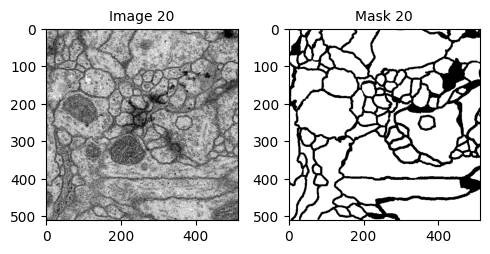

In [29]:
ind = 20 # Set the index of the image and mask to display
plt.figure(figsize=(5, 3))
plt.subplot(121); plt.imshow(images[ind], cmap='gray'); plt.title(f'Image {ind}', fontsize=10)
plt.subplot(122); plt.imshow(masks[ind], cmap='gray'); plt.title(f'Mask {ind}', fontsize=10) 
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#dd7f05 size="4.5" face="Arial"><b>3️⃣ RGB to Gray</b></font><br/>
Simplify the images by reducing color channels.<br/>
▪ Convert RGB images to grayscale using a function like skimage.color.rgb2gray.<br/>
▪ Ensure masks remain unchanged as they are typically already binary.<br/>

In [49]:
# Define the directory path where the processed images will be saved
save_path = 'D:/Medical-Image-Processing/Data/'

# Use the `rgb_to_gray` method of the `ImageProcessor` object to convert RGB images to grayscale
# The `save_img_gray="on"` argument indicates that the grayscale images should be saved to the specified `save_path`
obj.save_grayscale_images(images, output_path=save_path, folder_name="Gray image")

Images are already grayscale; no conversion or saving needed.


<font color=#ec0995 size="4.5" face="Arial"><b>4️⃣ Image Resizing</b></font><br/>
Standardize image dimensions for consistent processing.<br/>
▪ Use skimage.transform.resize to adjust all images and masks to a uniform size (e.g., 256x256 pixels).<br/>
▪ Preserve the aspect ratio and data integrity during resizing.<br/>
**`Standardizing Image Dimensions:`** Machine learning models, like CNNs, need input data with fixed dimensions. For instance, if a model requires images of size 224x224x3, all input images must be resized to that shape.<br/>
**`Reducing Computational Load:`** Resizing images to smaller dimensions lowers computational costs, particularly with large datasets, and aids in faster training or inference for deep learning models.

In [31]:
images_resize = obj.read_images(image_path, format_type=img_format_type, resize=(224, 224))

Image shape: (30, 224, 224, 1)


<font color=#06defa size="4.5" face="Arial"><b>5️⃣ Augmentation</b></font><br/>
**Purpose:**<br/>
- `Increase Dataset Size:` Augmentation creates new training samples from existing ones, effectively increasing the dataset size.<br/>
- `Improve Model Robustness:` Introducing variations such as rotations, flips, and zooms helps the model adapt more effectively to real-world scenarios.<br/>
- `Prevent Overfitting:` Augmentation enhances variability, minimizing the likelihood of the model overfitting to the training data.<br/>

**Augmentation Techniques:**<br/>
- `Rotation:` Rotating images by a specified degree range (e.g., rotation_range=30).<br/>
- `Flip:` Flipping images horizontally or vertically.<br/>
- `Zoom:` Zooming in or out of images.<br/>
- `Shift:` Translating images horizontally or vertically.<br/>
- `Brightness/Contrast Adjustment:` Changing the brightness or contrast of images.<br/>
- `Noise Addition:` Adding random noise to images.<br/>

In [52]:
# Define the range of rotation for image augmentation (e.g., 30 degrees)
rotation_range = 30

# Define the number of augmented images to generate for each original image
num_augmented_imag = 1

# Path where augmented images will be saved
augmente_path = 'D:/Medical-Image-Processing/Data/'

# Call the `augmentation` method to perform image augmentation
obj.augmentation(images=images,augmente_path=augmente_path,rotation_range=rotation_range,num_augmented_images=num_augmented_imag,
                 format_type="png")

Generated and saved 30 augmented images to D:/Medical-Image-Processing/Data/augmented


<font color=#ecde11 size="4.5" face="Arial"><b>6️⃣ Crop images based on masks</b></font><br/>
Focus on regions of interest by removing irrelevant areas.<br/>
▪ Use the boolean mask to identify the foreground region in each image.<br/>
▪ Calculate the bounding box around the masked area.<br/>
▪ Crop both the image and mask to the bounding box dimensions.<br/>
▪ Visualize the original and cropped images/masks for validation<br/>

In [32]:
# Call the `mask_based_image_cropping` method to crop images and masks based on the mask boundaries
# The method returns two outputs:
# - `cropped_imgs`: Cropped versions of the input images.
# - `cropped_masks`: Cropped versions of the mask images.
cropped_imgs, cropped_masks = obj.crop_images_based_on_masks(images=images, masks=masks, resize=(256, 256))

Cropped 30 image-mask pairs. Image shape: (30, 256, 256), Mask shape: (30, 256, 256, 1)


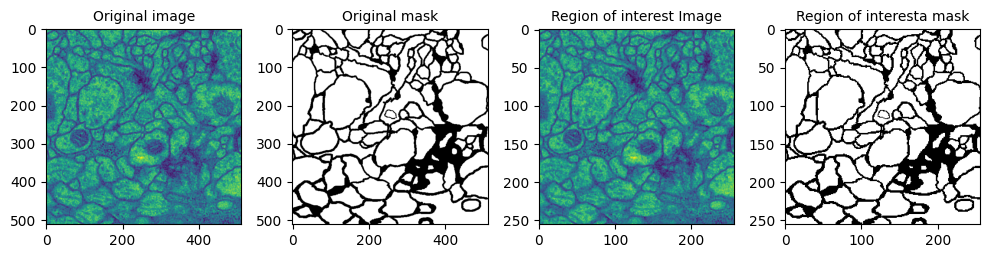

In [33]:
ind = 5 # Set the index of the image and mask to display
plt.figure(figsize=(10, 5))
plt.subplot(141); plt.imshow(images[ind]); plt.title('Original image', fontsize=10)
plt.subplot(142); plt.imshow(masks[ind], cmap='gray'); plt.title('Original mask', fontsize=10)
plt.subplot(143); plt.imshow(cropped_imgs[ind]); plt.title('Region of interest Image', fontsize=10)
plt.subplot(144); plt.imshow(cropped_masks[ind], cmap='gray'); plt.title('Region of interesta mask', fontsize=10) 
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#05e97e size="4.8" face="Arial"><b>7️⃣ Generate mask from image</b></font>

Generated 30 masks
Generated 30 masks
Generated 30 masks


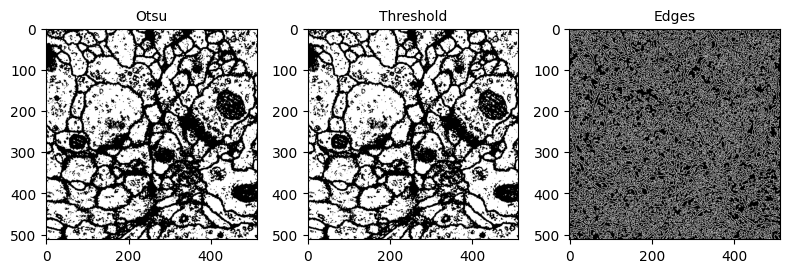

In [34]:
mask_otsu = obj.generate_mask_from_image(images=images, method="otsu") # Generate a mask using Otsu's method

# Generate a mask using a threshold value of 128
mask_threshold = obj.generate_mask_from_image(images=images, method='threshold', threshold=128)

mask_edges = obj.generate_mask_from_image(images=images, method='edges') # Generate a mask by detecting edges

plt.figure(figsize=(8, 5)) # Create a new figure with a specified size

# Display the Otsu mask in the first subplot
plt.subplot(131); plt.imshow(mask_otsu[0], cmap='gray'); plt.title('Otsu', fontsize=10)

# Display the threshold mask in the second subplot
plt.subplot(132); plt.imshow(mask_threshold[0], cmap='gray'); plt.title('Threshold', fontsize=10) 

# Display the edge-based mask in the third subplot
plt.subplot(133); plt.imshow(mask_edges[0], cmap='gray'); plt.title('Edges', fontsize=10)
plt.tight_layout() # Adjust subplot parameters for a tight layout